<a href="https://colab.research.google.com/github/Glasiermedic/India-Health-Census/blob/master/India_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## India Demographics and Illness correlation

#### As a part of this project we are attempting to determine what areas our Company should focus its "RELEASE THE TENSION PROGRAM" Hypertension education and prevention program.  As part of our program we need to be able to predict the number of hypertension patients each state/district in india has. The data we are utilizing is from the 2012-2013 census for all of India.  We will first inspect the data to determine the size, variables, correlations, variable metrics and look for missing or problematic values.  


In [0]:
#@title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import seaborn as sns

from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

import warnings
# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd")

In [0]:
#@title
ind_cen = pd.read_csv('https://raw.githubusercontent.com/Glasiermedic/India-Health-Census/master/Key_indicator_districtwise.csv')

In [3]:
#@title
ind_cen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Columns: 644 entries, State_Name to ZZ_Sex_Ratio_At_Birth_Urban_Upper_Limit
dtypes: float64(614), int64(28), object(2)
memory usage: 1.4+ MB


#### First to check to make sure all entries are complete. The raw data set has 644 unique variables so we will need to be creative in using our attributes. By using ''.isna', '.count' and '.unique' attributes combined we can see if the variables have different value counts.  For our dataframe all the variables have the same number of values entered and that is also matches the shape of our data frame. 

In [4]:
#@title
ind_cen.isna().count().unique()

array([284])

#### We also need to address  all but two of the variables starting with "xx_" where ''x'' is equal to a capital letter of the alphabet(AA_variable 1, BB_variable2). It is much cleaner to have straight forward variable names (variable1, Variable2).  To do this we first create a new list of column names that contains the two variables that already have the improved labels we are looking for.  Than we use a loop to cycle through the current variable labels and append the label (which we are now treating as a string) with the first three characters removed.  We also print it to make sure we are getting what we needed out of the operation. 

In [0]:
#@title
col_new = ['State_Name ','State_District_Name ']
for col in ind_cen.columns[2:]:
  col_new.append(col[3:])
#print(col_new)  
ind_cen.columns = col_new  

In [0]:
#@title
# this function prints the items count and if requested
# the items in the list on a new lines. 
# stringlist is the list variable made into a string so it will print as well
def print_var(list_variable, stringlist, printyn):
  print('items in {}:{}'.format(stringlist,len(list_variable)))
  if printyn=='y':
    for item in list_variable:
      print (item)
    print("")  
  elif printyn =='n':
    print("")
  else:
    print("you needed to use 'y' or 'n' as third parameter")
    

In [7]:
#@title
print_var(col_new,'col_new','n')

items in col_new:644



#### There are eighteen variables in our dataframe that encompass the reports of hypertension.   Of those nine record any type of accute conditions, which would include hypertension.   Since we are trying to predict the total number of hypertension patients in a region we really should exclude all variables that include hypertension specifically and all those that capture "any type of accute" conditions.   

#### We also can see that there are variables that are actually the summation of other variables.  After removing the hypertension related variables I also created a totals only list and a totals included list.  I then ran them both through the correlation, scalar and KNN algorhythm and determined that the model performs leaving the totals in the dataset. 

In [56]:
#@title
#a list of all the variables containing data about hypertension
hyp_all_accute = []
# a list of all the variables excluding the 18 related to hypertension
non_hyp = []
#a list of only the variables that are totals of other variables
total_only_non_hyp = []
#a list excluding the hypertension and total variables. 
no_tot_non_hyp = []


# sorts the variables that contain or encompass the reports of hypertension
for item in ind_cen.columns:
  if 'Hypertension' in item:
    hyp_all_accute.append(item)
  elif 'Any_Type_Of_Acute' in item:
    hyp_all_accute.append(item)
  else:
    non_hyp.append(item)
      
#we need to add two variables we want to our total_only list      
for item in non_hyp:
  if 'State' in non_hyp:
    total_only_non_hyp.append(item)
    no_tot_non_hyp.append(item)
#now we can add the varables that are totals of other variables to the list
for item in non_hyp:
  if 'Total'in item:
      total_only_non_hyp.append(item)
  else:
    no_tot_non_hyp.append(item)
    
      
#Now we will check our lists
    
print_var(ind_cen.columns,'ind_cen.columns','n')


print_var(hyp_all_accute,'hyp_all_accute','n')

print_var(non_hyp,'non_hyp','n')

print_var(total_only_non_hyp,'total_only_non_hyp','n')

print_var(no_tot_non_hyp,'no_tot_non_hyp','n')



items in ind_cen.columns:644

items in hyp_all_accute:18

items in non_hyp:626

items in total_only_non_hyp:216

items in no_tot_non_hyp:410



#### We are going to use "non_hyp" as our list of variables to create our new varient of the original data set preserving the original set. 

In [9]:
#@title
xTI = ind_cen.copy

xTI = ind_cen[list(non_hyp)]

print ("Total Included",xTI.shape)

Total Included (284, 626)


#### Now we will assign the target variable ('Having_Diagnosed_For_Chronic_Illness_Per_100000_Population_Hypertension_Person_Total') to Y


In [10]:
#@title

#Y = ind_cen.iloc[:,227]
Y = ind_cen['Having_Diagnosed_For_Chronic_Illness_Per_100000_Population_Hypertension_Person_Total']

xTI.shape

(284, 626)

#### Now we will check to see what features are correlated with each other and eliminate those with the highest correlation.   

In [0]:
#@title
def corr_dataframe(dataframe,decimal_percentage):
  correlated_features = set()  
  correlation_matrix = dataframe.corr()
  for i in range(len(correlation_matrix .columns)):  
      for j in range(i):
          if abs(correlation_matrix.iloc[i, j]) > decimal_percentage and i!= j:
              colname = correlation_matrix.columns[i]
              correlated_features.add(colname)
  #print(correlation_matrix)
  print("the dimensions of the dataframe are:{} when we set the precentage to %{}".format(dataframe.shape,decimal_percentage*100))
  #print(correlated_features) 
  print(len(correlated_features))
  return correlated_features

In [12]:
#@title
TI_corrlist =list(corr_dataframe(xTI,.994))


the dimensions of the dataframe are:(284, 626) when we set the precentage to %99.4
58


In [13]:
#@title
xTI = xTI[TI_corrlist]
xTI.shape

(284, 58)

In [0]:
#@title
# This cell has been marked up because of the size of the maxtrix and label of the variables being too big for it to be useful


#corr_metrics = xTI.corr()

#corr_metrics.style.background_gradient()

#### Prior to running any algorhythms we need to verify our values are not too big, missing or infinity. 

#### Some of our features selected through the correlation matrix contain missing data.  We could drop the variables from the dataframe but it might be more useful for our models if we just insert the average for each variable back into the missing entries 

In [0]:
#@title
#ind_cenTI.isnull().sum()
xTI = xTI.fillna(method='bfill')




#### Convering all variables to z-scores or minmax scale

cols = list(xTI.columns)

for col in cols:
  xTI[col] = (xTI[col] - xTI[col].mean())/xTI[col].std(ddof=0)



In [16]:
#@title
scaler = StandardScaler(0,1)
xTI_scale = scaler.fit_transform(xTI)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Text(0.5, 0, 'Principal Component #')

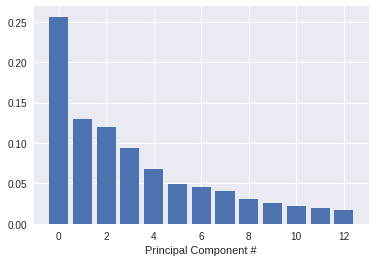

In [17]:
#@title
pca = PCA(n_components=13)
pca.fit(xTI_scale)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(13), exp_variance)
ax.set_xlabel('Principal Component #')

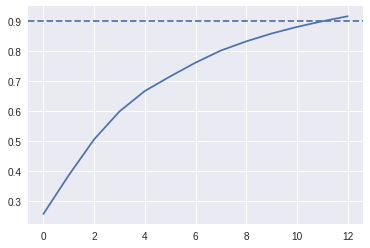

In [18]:
#@title
# Import numpy
import numpy as np

# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 0.90.
fig, ax = plt.subplots()
ax.plot(range(13), cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')
n_components = 11

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(xTI_scale)
pca_projection = pca.transform(xTI_scale)

In [0]:
#@title
#xTI.head()

In [0]:
#@title
X_train, X_test, y_train, y_test = train_test_split(pca_projection, Y, test_size=0.2, random_state=1)

In [21]:
#@title

X1 = X_train
Y1 = y_train



# Build our model.
k_changing = 5
knn2 = neighbors.KNeighborsRegressor(n_neighbors=k_changing, weights='distance')
knn2.fit(X1,Y1)

score2 = cross_val_score(knn2, X1, Y1, cv=5)
print("For the varient we created, the Weighted Accuracy using {} nearest neighbors: {} (+/- {})".format(k_changing, score2.mean(), score2.std()*2))
y_pred = knn2.predict(X_test).ravel()
print("Root mean square error {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))


For the varient we created, the Weighted Accuracy using 5 nearest neighbors: 0.7830121644679083 (+/- 0.15851723299120885)
Root mean square error 526.701788384918


### Results for Weighted KNN using 5 nearest neightbors and cross validation

#### This algorhythm currently can explain 78.3% of the variance in the total number of reported Hypertensive patients using our features .  It can predict the number of hypertension patients that will be reported to within 526 people.

#### Finally we will use Grid Search to find the optimum number of neighbors to get the best accuracy.    

#### When I ran the model above I used 5 nearest neighbors so we will see what the Grid Search comes up with and if it is an improvement overall

In [0]:
#@title
L = np.arange(1, 21, 1).tolist()
all =pd.DataFrame(columns=L)
all_scores =[]
all_ks = []
scores_array = np.zeros((20, 5))

for k2 in range(1,21,1):
  knn2 = neighbors.KNeighborsRegressor(n_neighbors=k2, weights='distance')
  knn2.fit(X1, Y1)
  score2 = cross_val_score(knn2, X1, Y1, cv=5)
  scores_array[k2-1,:] = score2
  
  result = pd.DataFrame(scores_array).T
  


In [0]:
#@title
result.columns=range(1, 21, 1)

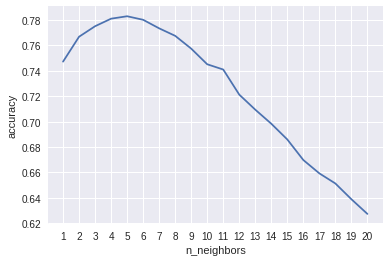

In [24]:
#@title
plt.plot(range(1, 21), result.apply(np.mean).values)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(range(1, 21))
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


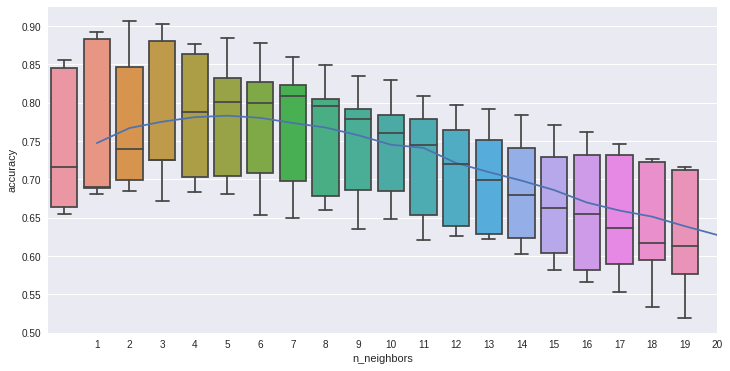

In [25]:
#@title
plt.figure(figsize=(12, 6))
sns.boxplot(result)

plt.plot(range(1, 21), result.apply(np.mean).values)
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(range(1, 21))

plt.show()


In [0]:
#@title
kf = KFold(10, random_state=10)
i = 0
for train_index, test_index in kf.split(X1):
  #print(pca_projection[train_index])
  #print(pca_projection[test_index])
  i = i+1
  #print(i)
  #break

In [27]:
#@title
params = {'n_neighbors': range(1, 20),
         'weights': ['uniform', 'distance']}

grid = GridSearchCV(KNeighborsRegressor(), param_grid=params , cv=kf)
grid.fit(X1, Y1)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=10, shuffle=False),
       error_score='raise-deprecating',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(1, 20), 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [28]:
#@title
print("the best score using Grid Search:")
grid.best_score_

the best score using Grid Search:


0.743705945173369

In [29]:
#@title
print("the best parameters found by Grid Search:")
grid.best_params_

the best parameters found by Grid Search:


{'n_neighbors': 4, 'weights': 'distance'}

In [30]:
#@title
from sklearn.metrics import mean_squared_error
X1 = X_train
Y1 = y_train



# Build our model.
k_changing = 4
knn2 = neighbors.KNeighborsRegressor(n_neighbors=k_changing, weights='distance')
knn2.fit(X1,Y1)

score2 = cross_val_score(knn2, X1, Y1, cv=5)
print("For the varient we created, the Weighted Accuracy using {} nearest neighbors: {} (+/- {})".format(k_changing, score2.mean(), score2.std()*2))
y_pred = knn2.predict(X_test).ravel()
print("Root mean square error {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

For the varient we created, the Weighted Accuracy using 4 nearest neighbors: 0.7810940982163539 (+/- 0.1851849318035863)
Root mean square error 565.7347792924583


### Results for Weighted KNN using suggested values from Grid Search (4 nearest neighbors)

#### This algorhythm currently can explain 78.1% of the variance in the total number of reported Hypertensive patients using our features .  It can predict the number of hypertension patients that will be reported to within 565 people.

### Linear Regression with cross validation 

In [31]:
#@title
TI_corrlist2 =list(corr_dataframe(xTI,.2))
X2 = xTI[TI_corrlist2]
X2.shape
Y2=ind_cen['Having_Diagnosed_For_Chronic_Illness_Per_100000_Population_Hypertension_Person_Total']


the dimensions of the dataframe are:(284, 58) when we set the precentage to %20.0
54


In [0]:
#@title
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=1)

['Having_Diagnosed_For_Any_Kind_Of_Chronic_Illness_And_Getting_Regular_Treatment_From_Government_Source_Male_Total', 'Children_Who_Received_Foods_Other_Than_Breast_Milk_During_First_6_Months_Water_Rural', 'Having_Diagnosed_For_Any_Kind_Of_Chronic_Illness_And_Getting_Regular_Treatment_From_Government_Source_Male_Rural', 'Delivery_At_Home_Total', 'Having_Diagnosed_For_Chronic_Illness_Per_100000_Population_Any_Kind_Of_Chronic_Illness_Male_Rural', 'Average_Month_By_Which_Children_Received_Foods_Other_Than_Breast_Milk_Water_Rural', 'Persons_Suffering_From_Acute_Illness_Per_100000_Population_Acute_Respiratory_Infection_Ari_Female_Urban', 'Persons_Suffering_From_Acute_Illness_Per_100000_Population_Fever_All_Types_Male_Total', 'Persons_Suffering_From_Acute_Illness_And_Taking_Treatment_From_Government_Source_Male_Rural', 'Having_Diagnosed_For_Chronic_Illness_Per_100000_Population_Any_Kind_Of_Chronic_Illness_Female_Total', 'Persons_Suffering_From_Acute_Illness_And_Taking_Treatment_From_Governmen

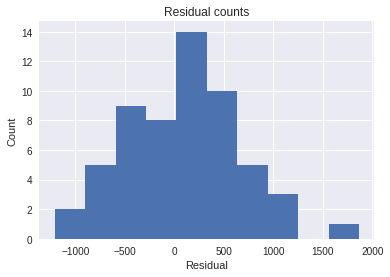

In [33]:
#@title
from sklearn.metrics import mean_squared_error

regr = linear_model.LinearRegression()
Y = (y2_train.values.reshape(-1, 1))




X = (X2_train)
regr.fit(X, Y)

# Inspect the results.
print(TI_corrlist)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))



# Extract predicted values.
predicted = regr.predict(X2_test).ravel()
actual = y2_test

print("Root mean square error {}".format(np.sqrt(mean_squared_error(actual, predicted))))
 
# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

### Results from Linear Regression model

#### This algorhythm currently can explain 85.3% of the variance in the total number of reported Hypertensive patients using our features .  It can predict the number of hypertension patients that will be reported to within 595 people  

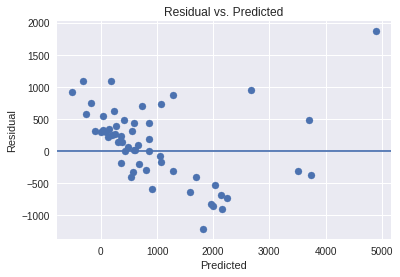

In [34]:
#@title
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### I attempted to use a cross validation and according to the averaged Rsquared our model can explain 52% of the varience of our target using our features. 

In [37]:
#@title
from sklearn.model_selection import cross_val_predict
score3 = cross_val_score(regr, X, Y, cv=10)

print("For the varient we created the Accuracy : {} (+/- {})".format( score3.mean(), score3.std()*2))
predicted = cross_val_predict(regr, X, Y, cv=10)
actual = y2_test



For the varient we created the Accuracy : 0.5243303090201098 (+/- 0.4664639479327501)


### Stochastic Gradient Descent

In [47]:
#@title
TI_corrlist2 =list(corr_dataframe(xTI,.998))
X= xTI[TI_corrlist2]

#X.shape
Y=ind_cen['Having_Diagnosed_For_Chronic_Illness_Per_100000_Population_Hypertension_Person_Total']

X = X.fillna(method='bfill')
#X.shape

the dimensions of the dataframe are:(284, 58) when we set the precentage to %99.8
3


In [48]:
#@title
X.isnull().sum()
xisnull =X.columns[[list((np.where((X.isna().sum()) > 0))[0])]]
xisnull.tolist()

[]

In [0]:
#@title
#X.columns[[277, 278]]
#X = X.drop(xisnull.tolist(), axis=1)
#X.shape


In [0]:
#@title
X3_train, X3_test, y3_train, y3_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [0]:
#@title
from sklearn import linear_model
clf = linear_model.SGDRegressor(max_iter=1000, tol=1e-3)

In [0]:
#@title
ynew = (y3_train.values.reshape(-1, 1))

In [52]:
#@title
clf.fit(X3_train, ynew)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [53]:
#@title
clf.get_params(deep=True)

{'alpha': 0.0001,
 'average': False,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.01,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'invscaling',
 'loss': 'squared_loss',
 'max_iter': 1000,
 'n_iter': None,
 'n_iter_no_change': 5,
 'penalty': 'l2',
 'power_t': 0.25,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


Intercept: 
 [-7.75523999e+10]

R-squared:
-9.324063968464222e+26
Root mean square error 3.4625494559386748e+16


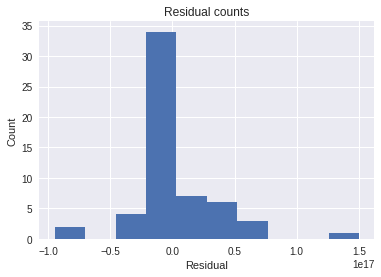

In [54]:
#@title
# Inspect the results.
#print(TI_corrlist)
#print('\nCoefficients: \n', clf.coef_)
print('\nIntercept: \n', clf.intercept_)
print('\nR-squared:')
print(clf.score(X3_test, y3_test))



# Extract predicted values.
predicted = clf.predict(X3_test).ravel()
actual = y3_test

print("Root mean square error {}".format(np.sqrt(mean_squared_error(actual, predicted))))
 
# Calculate the error, also called the residual.
residual = actual - predicted


plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

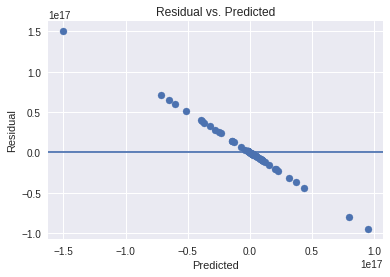

In [55]:
#@title
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Results from Stochastic Gradient Descent

#### It is not a reliable model in its raw state and since the other models perform better I have decided to not to pursue it further. 

## Conclusion

### Data cleaning phase:
#### This dataset contained more variables than there were entries.  It also has very long names for the variables which made it difficult at times to create visuals.  The data also contains missing values and two variables that are categorical.  We were able to address all the issues along with prepping the data for different models. I created a variant of the datframe that didn't inlcude any of the variables that measured hypertension and those that were inclusive for hypertension (counted the number of hypertensive patients as a part of their value). 

### Feature Engineering
#### I utlized PCA, a correlation matrix and two methods of scaling the data along with preselecting some of the variables to be excluded from the training model.  The correlation matrix was very useful in selecting the variables that had the least correlation.  THe PCA also was very useful in creating a more managable set of features to work with.  I did use a Grid Search to help fine tune the parameters of our KNN algorhythm along with the visual created from the cross validation.  In the end I think the combination of features engineering and parameter tuning helped to create better models. 

### Algorhythms and outcomes
#### For this project I have used PCA, Stochastic Gradient Descent, KNN, Weighted KNN and Linear Regression.  Of the predicting algorhythms I have conlcuded that Linear Regression and KNN are definitely the better models.  Linear Regression performed 

